###Team Members: 
###Harikishan Takoor - 20BAI1297
###Sarvesh Chandak - 20BAI1221

# Download and Unzip Dataset 

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7" -O Dataset.zip && rm -rf /tmp/cookies.txt

--2022-11-18 14:58:37--  https://docs.google.com/uc?export=download&confirm=t&id=1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7
Resolving docs.google.com (docs.google.com)... 108.177.119.101, 108.177.119.100, 108.177.119.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gg98i2bec6knpigg4mv1cvvr3vi02pqa/1668783450000/14323669513596321114/*/1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7?e=download&uuid=b3bd9b4b-75e3-42b9-bdf9-3b79660b3d05 [following]
--2022-11-18 14:58:37--  https://doc-0s-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gg98i2bec6knpigg4mv1cvvr3vi02pqa/1668783450000/14323669513596321114/*/1n-wc8ebopNacuTNdtGrkn7A7r7UOjBj7?e=download&uuid=b3bd9b4b-75e3-42b9-bdf9-3b79660b3d05
Resolving doc-0s-20-docs.googleusercontent.com (doc-0s-20-docs.googleusercontent.com)... 142.250.145.

In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
   creating: Dataset/walking/
  inflating: Dataset/walking/person01_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d3_uncomp.av

# Import Required Libraries

In [ ]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 28.2 MB/s 


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Select Randomness

In [ ]:
seed_constant = 5
# np.random.seed(seed_constant)
# random.seed(seed_constant)
# tf.random.set_seed(seed_constant)

# View the dataset

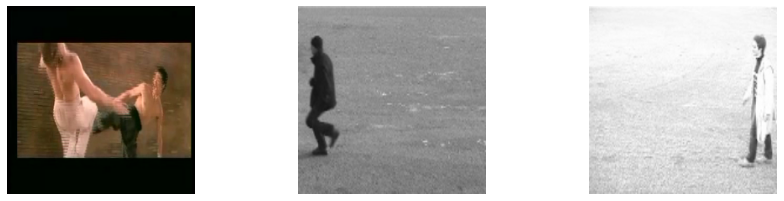

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('Dataset')

# Iterating through all the generated random values.
for counter, random_index in enumerate(range(len(all_classes_names)), 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
  
    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


# Set Dataset Variables

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "Dataset"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["walking", "fights", "running"]

# Data pre-processing

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: walking
Extracting Data of Class: fights
Extracting Data of Class: running


In [ ]:
# Returns shape of features & labels
print(features.shape, labels.shape)

(300, 30, 64, 64, 3) (300,)


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# Model Creation LRCN (Long-term Recurrent Convolutional Network)
### LRCN is combination of CNN and LSTM. It is suitable for large-scale visual understanding tasks such as activity detection. LRCN processes the variable-length visual input with a CNN. Their output are fed into a stack of recurrent sequence models (LSTM). The final output from the LSTM is a vaiable-length prediction. This makes LRCN proper model to handle tasks with time-varying inputs and output.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 16, 16, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4, 4, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 4, 4, 128)    7

# Model Training

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/70
42/42 [==============================] - 11s 34ms/step - loss: 0.7431 - accuracy: 0.5952 - val_loss: 0.7554 - val_accuracy: 0.6316
Epoch 2/70
42/42 [==============================] - 1s 15ms/step - loss: 0.5968 - accuracy: 0.6548 - val_loss: 0.4520 - val_accuracy: 0.7018
Epoch 3/70
42/42 [==============================] - 1s 15ms/step - loss: 0.4882 - accuracy: 0.6548 - val_loss: 0.4173 - val_accuracy: 0.7719
Epoch 4/70
42/42 [==============================] - 1s 15ms/step - loss: 0.4786 - accuracy: 0.7083 - val_loss: 0.4216 - val_accuracy: 0.7018
Epoch 5/70
42/42 [==============================] - 1s 15ms/step - loss: 0.4425 - accuracy: 0.7560 - val_loss: 0.3674 - val_accuracy: 0.8246
Epoch 6/70
42/42 [==============================] - 1s 15ms/step - loss: 0.4237 - accuracy: 0.8036 - val_loss: 0.3531 - val_accuracy: 0.8421
Epoch 7/70
42/42 [==============================] - 1s 15ms/step - loss: 0.4808 - accuracy: 0.7202 - val_loss: 0.4036 - val_accuracy: 0.7368
Epoch 8/70
4

# Save Model

In [ ]:
# Save your Model.
model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

# Plot Loss and Accuracy Graphs while Training

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

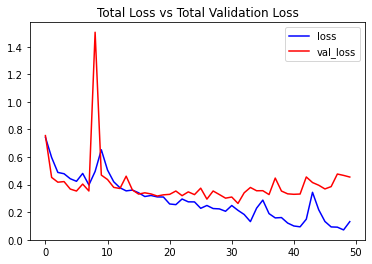

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

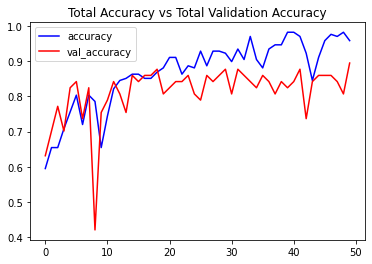

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Accuracy on Test Dataset

In [ ]:
# Calculate Accuracy On Test Dataset
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 17ms/step
Accuracy = 82.66666666666667
